Mounted at /content/drive
Device: cuda
Model: Swin Transformer V2 (Window 8, 256px)

[PROCESS] 1. Menyiapkan Dataset A...
   -> Scanning Root: train | Kelas Utama: ['Benign', 'InSitu', 'Invasive', 'Normal']
   -> Scanning Root: val | Kelas Utama: ['Benign', 'InSitu', 'Invasive', 'Normal']
   -> Scanning Root: test | Kelas Utama: ['Benign', 'InSitu', 'Invasive', 'Normal']

[PROCESS] 2. Menyiapkan Breakhis (Deep Scan)...
   -> Scanning Root: Breakhis_200x | Kelas Utama: ['benign', 'malignant']
   Total gambar Breakhis ditemukan: 2013

[PROCESS] 3. Menggabungkan Dataset...
   Train Size : 1991 (A + Breakhis)
   Val Size   : 342 (A + Breakhis)
   Test Size  : 80 (Dataset A Only)

[INFO] Mapping Kelas: {'benign': 0, 'insitu': 1, 'invasive': 2, 'malignant': 3, 'normal': 4}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]


   >> RUN 1 dimulai (Seed 42)...


   >> Run 1 Selesai. Best Val F1: 0.9678
   -> Result Run 1 (Test F1): 0.8001




   >> RUN 2 dimulai (Seed 2024)...


   >> Run 2 Selesai. Best Val F1: 0.9713
   -> Result Run 2 (Test F1): 0.8231


   >> RUN 3 dimulai (Seed 999)...


   >> Run 3 Selesai. Best Val F1: 0.9706
   -> Result Run 3 (Test F1): 0.6814


 HASIL AKHIR SWIN V2 (Best Run: 2)
 Evaluasi pada Test Set Dataset A


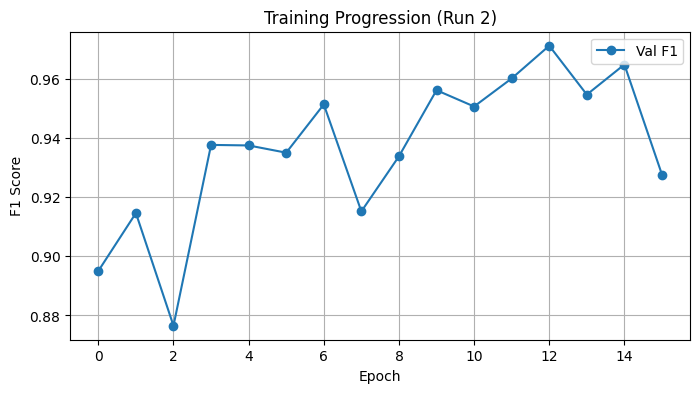

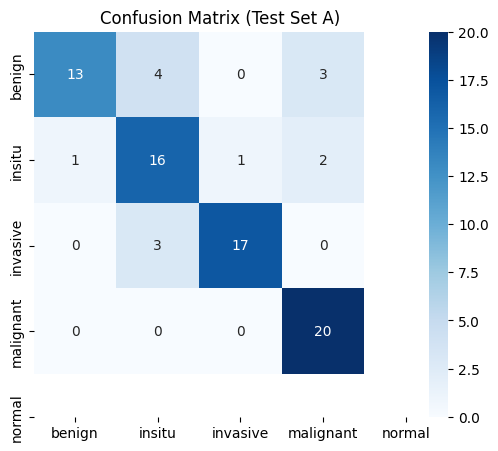


[CLASSIFICATION REPORT]


ValueError: Number of classes, 4, does not match size of target_names, 5. Try specifying the labels parameter

In [ ]:
# ==============================================================================
#  FINAL ROBUST PIPELINE: SWIN TRANSFORMER V2 + COMBINED DATASETS
#  Fitur Utama:
#  1. Model: Swin Transformer V2 (High Resolution Window Attention).
#  2. Deep Scan: Membaca sub-folder (adenosis, dll) secara rekursif.
#  3. Stability: num_workers=0 & IMG_SIZE=256 (Optimal untuk Swin).
#  4. Fair Comparison: Training Gabungan, Testing HANYA pada Dataset A.
# ==============================================================================

import subprocess
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive

# --- 1. INSTALL LIBRARY ---
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import timm
except ImportError:
    print("Installing timm...")
    install('timm')
    import timm

# --- 2. KONFIGURASI PATH (PASTIKAN INI BENAR) ---
# Sesuaikan dengan lokasi folder Anda di Google Drive
PATH_DATASET_A = '/content/drive/MyDrive/Breastcancerimager'
PATH_BREAKHIS  = '/content/drive/MyDrive/Breakhis_200x'

# Hyperparameters (Updated for Swin Transformer)
IMG_SIZE = 256  # Swin V2 optimal pada 256x256 (Window Size 8)
BATCH_SIZE = 32
LEARNING_RATE = 5e-5 # Swin lebih stabil dengan LR sedikit lebih kecil
EPOCHS = 16
NUM_RUNS = 3
SEEDS = [42, 2024, 999]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

print(f"Device: {DEVICE}")
print(f"Model: Swin Transformer V2 (Window 8, 256px)")

# ==============================================================================
#  BAGIAN 1: DATA MANAGER (DEEP RECURSIVE SCAN)
# ==============================================================================

class CombinedDataManager:
    def __init__(self, path_a, path_breakhis):
        self.path_a = path_a
        self.path_b = path_breakhis

    def get_df_recursive(self, folder_path):
        """
        Fungsi ini mencari gambar hingga ke folder terdalam (Sub-folder).
        """
        if not os.path.exists(folder_path):
            print(f"[WARNING] Path tidak ditemukan: {folder_path}")
            return pd.DataFrame(columns=['filepath', 'label'])

        filepaths = []
        labels = []

        # Ambil nama folder kelas utama
        try:
            classes = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
        except:
            return pd.DataFrame(columns=['filepath', 'label'])

        print(f"   -> Scanning Root: {os.path.basename(folder_path)} | Kelas Utama: {classes}")

        for label in classes:
            class_path = os.path.join(folder_path, label)

            # Deep Search (os.walk)
            count_per_class = 0
            for root, dirs, files in os.walk(class_path):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                        fpath = os.path.join(root, file)
                        filepaths.append(fpath)
                        labels.append(label.lower())
                        count_per_class += 1

        df = pd.DataFrame({'filepath': filepaths, 'label': labels})
        return df

    def prepare_combined_data(self):
        print("\n[PROCESS] 1. Menyiapkan Dataset A...")
        df_train_a = self.get_df_recursive(os.path.join(self.path_a, 'train'))
        df_val_a   = self.get_df_recursive(os.path.join(self.path_a, 'val'))
        df_test_a  = self.get_df_recursive(os.path.join(self.path_a, 'test'))

        print("\n[PROCESS] 2. Menyiapkan Breakhis (Deep Scan)...")
        df_full_b = self.get_df_recursive(self.path_b)

        if not df_full_b.empty:
            print(f"   Total gambar Breakhis ditemukan: {len(df_full_b)}")
            # Split Breakhis: Masuk ke Train & Val, TAPI TIDAK KE TEST
            X = df_full_b['filepath']
            y = df_full_b['label']
            try:
                df_train_b, df_val_b = train_test_split(df_full_b, test_size=0.15, stratify=y, random_state=42)
            except ValueError:
                df_train_b, df_val_b = train_test_split(df_full_b, test_size=0.15, random_state=42)
        else:
            print("   [ERROR] Breakhis masih kosong! Pastikan path benar.")
            df_train_b = pd.DataFrame()
            df_val_b = pd.DataFrame()

        # MERGE DATASETS
        print("\n[PROCESS] 3. Menggabungkan Dataset...")
        final_train = pd.concat([df_train_a, df_train_b], ignore_index=True)
        final_val = pd.concat([df_val_a, df_val_b], ignore_index=True)
        final_test = df_test_a # Penting: Test set murni dari Dataset A

        print(f"   Train Size : {len(final_train)} (A + Breakhis)")
        print(f"   Val Size   : {len(final_val)} (A + Breakhis)")
        print(f"   Test Size  : {len(final_test)} (Dataset A Only)")

        return final_train, final_val, final_test

class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None, class_map=None):
        self.df = df
        self.transform = transform
        self.class_map = class_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['filepath']
        label_str = row['label']

        if label_str in self.class_map:
            label = self.class_map[label_str]
        else:
            label = 0

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), label

# Augmentasi Gambar (Resize ke 256)
transforms_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==============================================================================
#  BAGIAN 2: MODEL (SWIN TRANSFORMER V2 - HIGH PERFORMANCE)
# ==============================================================================

class SwinV2_Custom(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(SwinV2_Custom, self).__init__()

        # Load Swin Transformer V2 (Tiny, Window 8, 256px)
        # Varian 'tiny' ini lebih kuat daripada ResNet50 biasa
        self.backbone = timm.create_model(
            'swinv2_tiny_window8_256.ms_in1k',
            pretrained=pretrained,
            num_classes=0 # Remove default head
        )
        num_features = self.backbone.num_features

        # Custom Classifier Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(num_features),
            nn.Dropout(0.3),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        out = self.classifier(features)
        return out

# ==============================================================================
#  BAGIAN 3: TRAINING LOOP
# ==============================================================================

def train_one_run(run_id, train_loader, val_loader, test_loader, num_classes, seed):
    # Set Random Seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Inisialisasi Model Swin V2
    model = SwinV2_Custom(num_classes=num_classes, pretrained=True).to(DEVICE)

    # Optimizer (AdamW sangat disarankan untuk Transformer)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
    criterion = nn.CrossEntropyLoss()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

    best_f1 = 0.0
    history = {'loss': [], 'val_f1': []}
    model_save_path = f"best_swin_model_run_{run_id}.pth"

    print(f"\n   >> RUN {run_id} dimulai (Seed {seed})...")

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0

        # Training Loop
        for imgs, lbls in tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False):
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()

            # Gradient Clipping (Penting untuk kestabilan Transformer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        # Validation Loop
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs = imgs.to(DEVICE)
                out = model(imgs)
                _, p = torch.max(out, 1)
                preds.extend(p.cpu().numpy())
                targets.extend(lbls.numpy())

        val_f1 = f1_score(targets, preds, average='weighted')
        history['loss'].append(train_loss/len(train_loader))
        history['val_f1'].append(val_f1)

        scheduler.step(val_f1)

        # Simpan Model Terbaik
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), model_save_path)

    print(f"   >> Run {run_id} Selesai. Best Val F1: {best_f1:.4f}")

    # --- FINAL TEST EVALUATION ---
    model.load_state_dict(torch.load(model_save_path, weights_only=True))
    model.eval()

    t_preds, t_targets, t_probs = [], [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)
            _, p = torch.max(out, 1)
            t_preds.extend(p.cpu().numpy())
            t_targets.extend(lbls.numpy())
            t_probs.extend(probs.cpu().numpy())

    final_test_f1 = f1_score(t_targets, t_preds, average='weighted')

    return {
        'run_id': run_id,
        'f1': final_test_f1,
        'history': history,
        'preds': t_preds,
        'targets': t_targets,
        'probs': np.array(t_probs)
    }

def analyze_final_results(results, class_map):
    best_res = max(results, key=lambda x: x['f1'])
    print(f"\n{'='*50}")
    print(f" HASIL AKHIR SWIN V2 (Best Run: {best_res['run_id']})")
    print(f" Evaluasi pada Test Set Dataset A")
    print(f"{'='*50}")

    # 1. Plot Grafik Training
    plt.figure(figsize=(8, 4))
    plt.plot(best_res['history']['val_f1'], marker='o', label='Val F1')
    plt.title(f'Training Progression (Run {best_res["run_id"]})')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Confusion Matrix
    cm = confusion_matrix(best_res['targets'], best_res['preds'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_map.keys(), yticklabels=class_map.keys())
    plt.title('Confusion Matrix (Test Set A)')
    plt.show()

    # 3. Text Report
    print("\n[CLASSIFICATION REPORT]")
    print(classification_report(best_res['targets'], best_res['preds'], target_names=class_map.keys()))

# ==============================================================================
#  MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    # 1. Siapkan Data
    manager = CombinedDataManager(PATH_DATASET_A, PATH_BREAKHIS)
    train_df, val_df, test_df = manager.prepare_combined_data()

    if not train_df.empty and not test_df.empty:
        # 2. Setup Kelas & Dataloader
        classes = sorted(train_df['label'].unique())
        class_map = {k: v for v, k in enumerate(classes)}
        print(f"\n[INFO] Mapping Kelas: {class_map}")

        # PENTING: num_workers=0 untuk mencegah crash di Colab
        train_loader = DataLoader(BreastCancerDataset(train_df, transforms_train, class_map),
                                  batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(BreastCancerDataset(val_df, transforms_val, class_map),
                                batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        test_loader = DataLoader(BreastCancerDataset(test_df, transforms_val, class_map),
                                 batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        # 3. Jalankan 3 Runs
        all_results = []
        for i, seed in enumerate(SEEDS):
            res = train_one_run(i+1, train_loader, val_loader, test_loader, len(classes), seed)
            all_results.append(res)
            print(f"   -> Result Run {i+1} (Test F1): {res['f1']:.4f}\n")

        # 4. Analisis
        analyze_final_results(all_results, class_map)
    else:
        print("\n[CRITICAL ERROR] Data kosong. Mohon periksa path Google Drive Anda.")

In [ ]:
def analyze_final_results(results, class_map):
    best_res = max(results, key=lambda x: x['f1'])
    print(f"\n{'='*50}")
    print(f" HASIL AKHIR SWIN V2 (Best Run: {best_res['run_id']})")
    print(f" Evaluasi pada Test Set Dataset A")
    print(f"{'='*50}")

    # 1. Plot Grafik Training
    plt.figure(figsize=(8, 4))
    plt.plot(best_res['history']['val_f1'], marker='o', label='Val F1')
    plt.title(f'Training Progression (Run {best_res["run_id"]})')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Confusion Matrix
    cm = confusion_matrix(best_res['targets'], best_res['preds'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_map.keys(), yticklabels=class_map.keys())
    plt.title('Confusion Matrix (Test Set A)')
    plt.show()

    # 3. Text Report (DIPERBAIKI)
    print("\n[CLASSIFICATION REPORT]")

    # Kita ekstrak list values (integers) dan keys (nama kelas)
    # Ini memaksa sklearn menghitung skor untuk semua kelas,
    # meskipun ada kelas yang tidak muncul di Test Set (skornya akan 0.00 untuk kelas itu)
    labels_list = list(class_map.values())
    target_names_list = list(class_map.keys())

    print(classification_report(
        best_res['targets'],
        best_res['preds'],
        labels=labels_list,          # Masukkan ID integer semua kelas (0, 1, 2, 3, 4)
        target_names=target_names_list, # Masukkan nama string semua kelas
        zero_division=0              # Agar tidak error jika ada kelas yang kosong
    ))


 HASIL AKHIR SWIN V2 (Best Run: 2)
 Evaluasi pada Test Set Dataset A


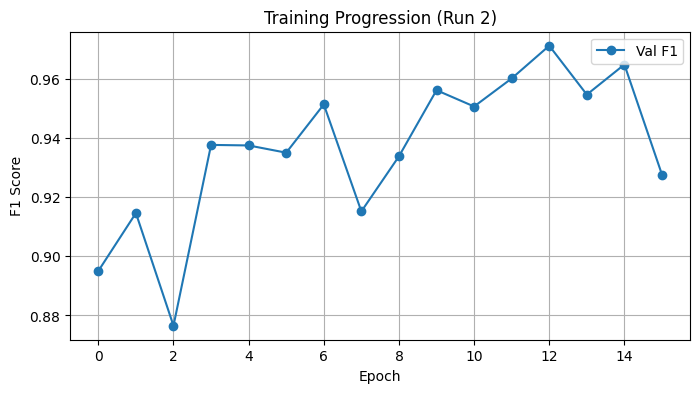

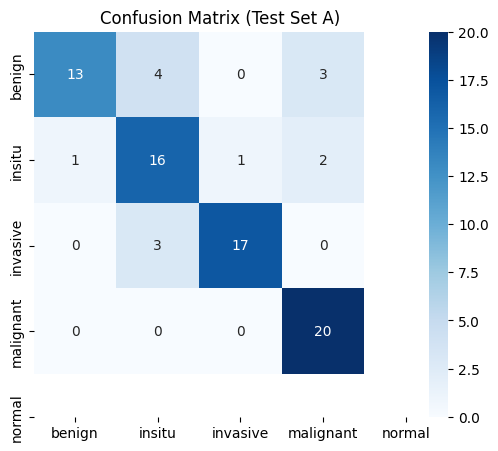


[CLASSIFICATION REPORT]
              precision    recall  f1-score   support

      benign       0.93      0.65      0.76        20
      insitu       0.70      0.80      0.74        20
    invasive       0.94      0.85      0.89        20
   malignant       0.00      0.00      0.00         0
      normal       0.80      1.00      0.89        20

    accuracy                           0.82        80
   macro avg       0.67      0.66      0.66        80
weighted avg       0.84      0.82      0.82        80



In [ ]:
# Jalankan analisis ulang dengan fungsi yang sudah diperbaiki
if 'all_results' in globals() and 'class_map' in globals():
    analyze_final_results(all_results, class_map)
else:
    print("Variabel hasil training hilang. Mohon jalankan training ulang dari awal.")


 VISUALISASI PREDIKSI SWIN V2 (SAMPEL TEST SET A) 


/tmp/ipython-input-196635317.py:84: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-196635317.py:84: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


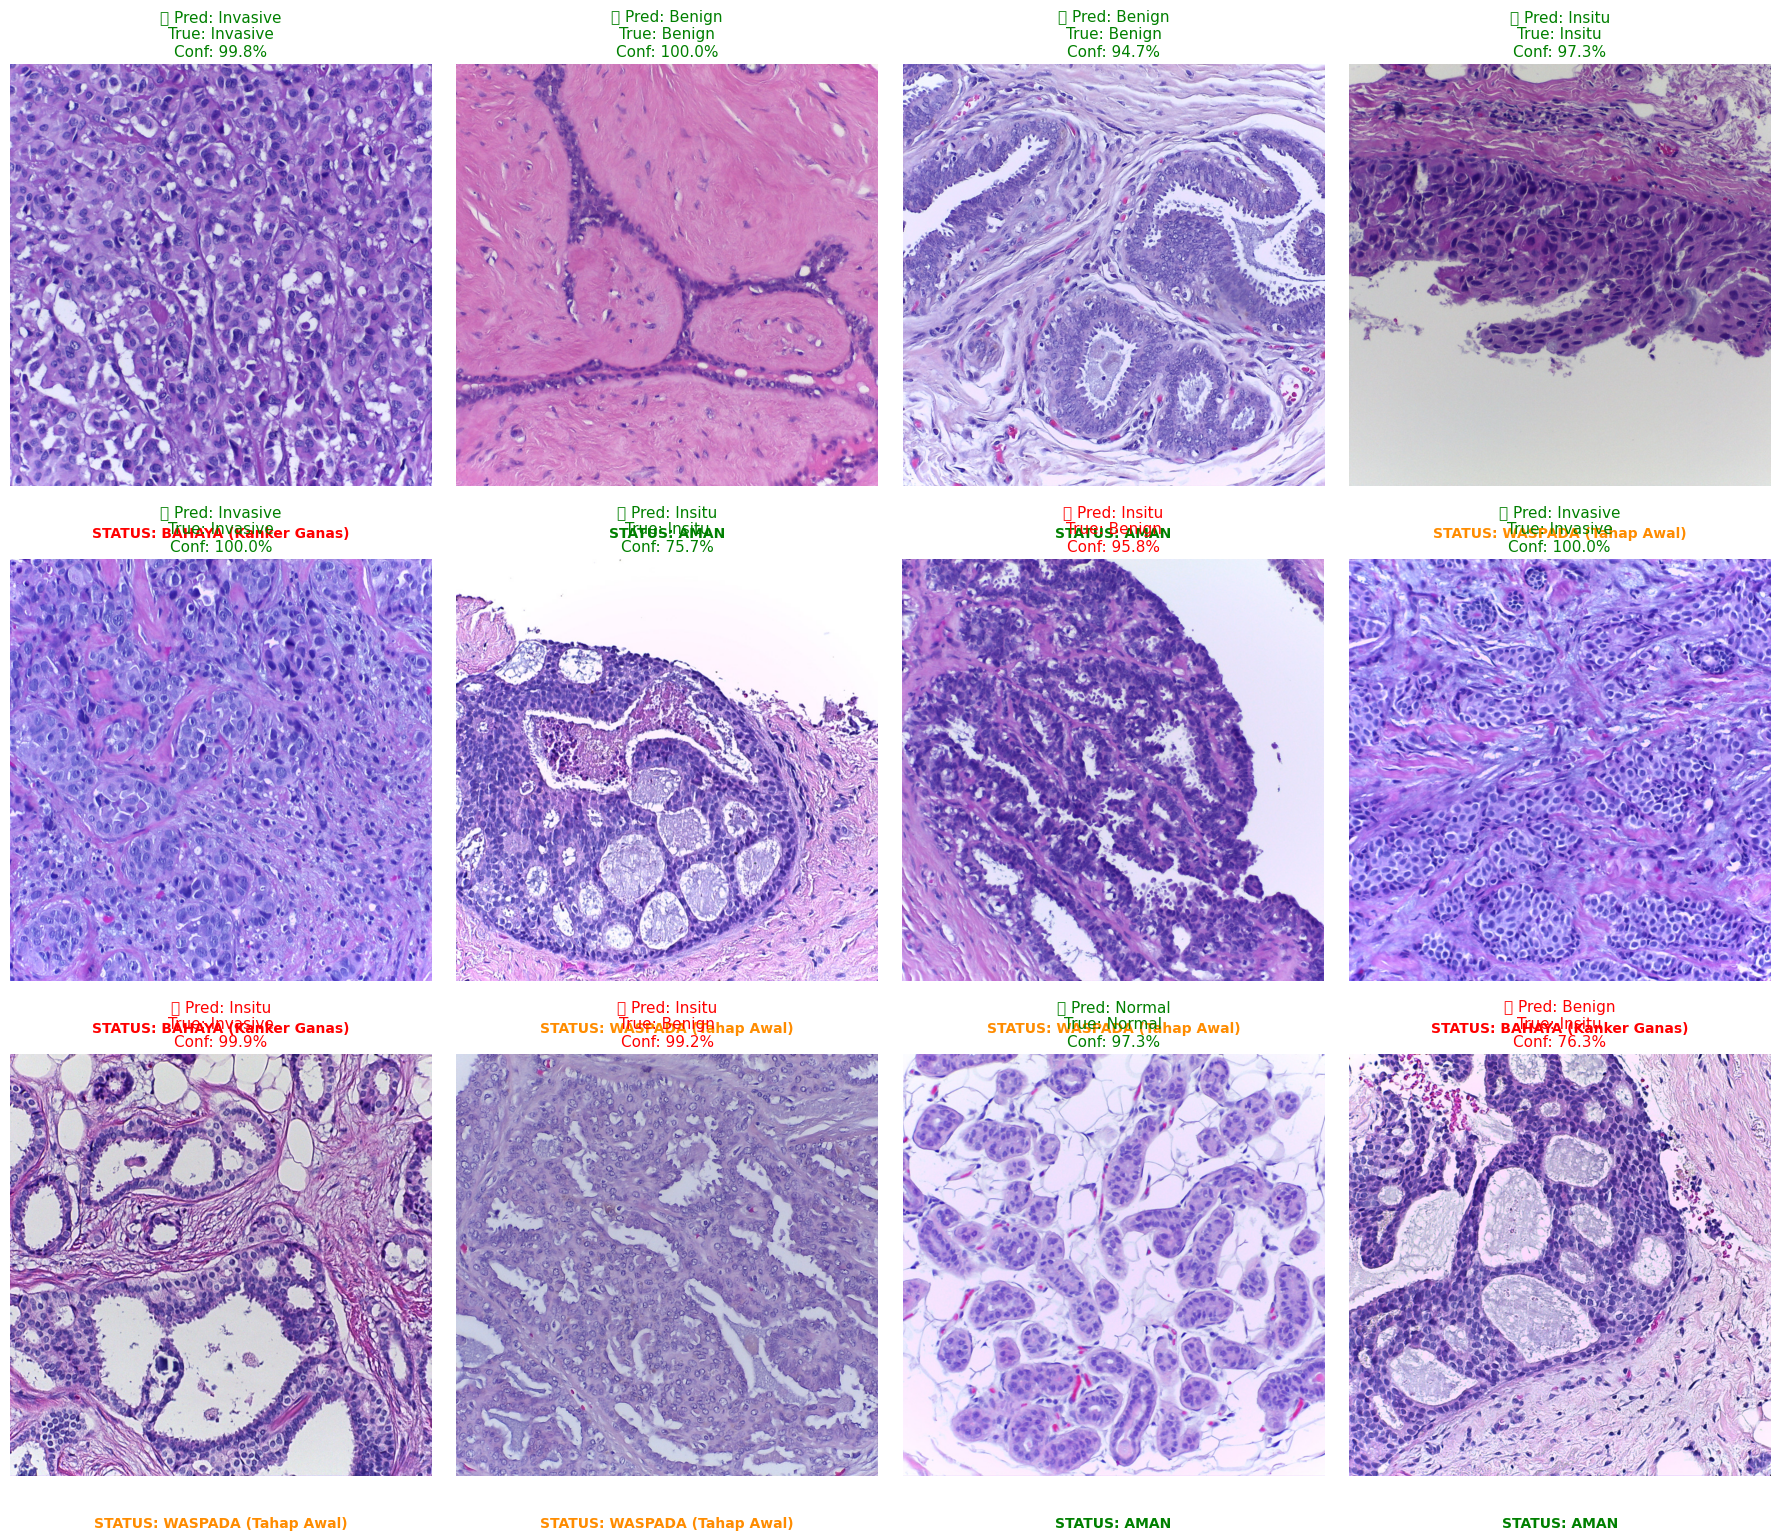

In [ ]:
# ==============================================================================
# BAGIAN 8: VISUALISASI PREDIKSI DARI DATA TEST (TANPA UPLOAD)
# ==============================================================================

def visualize_swin_predictions(model, test_df, class_map, transform, num_samples=12):
    print(f"\n{'='*50}")
    print(f" VISUALISASI PREDIKSI SWIN V2 (SAMPEL TEST SET A) ")
    print(f"{'='*50}")

    # 1. Setup Model & Device
    model.eval()
    model.to(DEVICE)

    # Balik class_map untuk mendapatkan nama dari index: {0: 'adenosis', 1: 'benign', ...}
    inv_class_map = {v: k.capitalize() for k, v in class_map.items()}

    # 2. Ambil Sampel Acak
    if len(test_df) < num_samples:
        num_samples = len(test_df)

    sample_df = test_df.sample(n=num_samples).reset_index(drop=True)

    # Setup Plot Grid
    cols = 4
    rows = (num_samples + cols - 1) // cols
    plt.figure(figsize=(18, 5 * rows))

    # 3. Loop Prediksi
    for i, row in sample_df.iterrows():
        img_path = row['filepath']
        true_label_str = row['label']

        try:
            # Load Gambar
            pil_img = Image.open(img_path).convert('RGB')

            # Preprocess (Resize & Normalize sesuai SwinV2)
            input_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

            # Prediksi
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)
                conf, pred_idx = torch.max(probs, 1)

            pred_idx = pred_idx.item()
            conf_score = conf.item() * 100
            pred_name = inv_class_map[pred_idx]
            true_name = true_label_str.capitalize()

            # --- LOGIKA STATUS (Sesuaikan dengan nama kelas di dataset Anda) ---
            # Contoh asumsi: normal/benign=Aman, in_situ=Waspada, invasive=Bahaya
            status_text = "STATUS: TIDAK TERDEFINISI"
            text_color = "black"

            if 'normal' in pred_name.lower() or 'benign' in pred_name.lower():
                status_text = "STATUS: AMAN"
                text_color = "green"
            elif 'insitu' in pred_name.lower() or 'in_situ' in pred_name.lower():
                status_text = "STATUS: WASPADA (Tahap Awal)"
                text_color = "darkorange"
            elif 'invasive' in pred_name.lower() or 'malignant' in pred_name.lower():
                status_text = "STATUS: BAHAYA (Kanker Ganas)"
                text_color = "red"

            # Plotting
            plt.subplot(rows, cols, i + 1)
            plt.imshow(pil_img)
            plt.axis('off')

            is_correct = (pred_name.lower() == true_label_str.lower())
            result_symbol = "✅" if is_correct else "❌"

            title = f"{result_symbol} Pred: {pred_name}\nTrue: {true_name}\nConf: {conf_score:.1f}%"
            plt.title(title, fontsize=11, color='green' if is_correct else 'red')

            # Tambahkan Teks Status di bawah gambar
            plt.text(0.5, -0.12, status_text, color=text_color, fontweight='bold',
                     ha='center', transform=plt.gca().transAxes)

        except Exception as e:
            print(f"Error pada file {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# ==============================================================================
# EKSEKUSI VISUALISASI
# ==============================================================================

# Kita ambil run terbaik atau inisialisasi model terakhir
# Pastikan 'test_df' dan 'class_map' sudah terdefinisi dari Bagian 1 & 3
if 'all_results' in locals() and len(all_results) > 0:
    # Ambil model dari run terbaik
    best_run_idx = max(range(len(all_results)), key=lambda i: all_results[i]['f1']) + 1
    best_model_path = f"best_swin_model_run_{best_run_idx}.pth"

    # Load model architecture
    final_model = SwinV2_Custom(num_classes=len(class_map), pretrained=False)
    final_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

    # Jalankan
    visualize_swin_predictions(
        model=final_model,
        test_df=test_df,
        class_map=class_map,
        transform=transforms_val,
        num_samples=12
    )
else:
    print("Silahkan jalankan proses Training terlebih dahulu.")

In [ ]:
# ==============================================================================
# SISTEM PREDIKSI & SARAN MEDIS AI (KANKER PAYUDARA) - SWIN VERSION
# ==============================================================================

import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image

def get_medical_advice(pred_idx, confidence, class_map):
    """
    Fungsi untuk memberikan saran medis berdasarkan kelas prediksi.
    Mapping disesuaikan dengan urutan alfabetis dari class_map pipeline.
    """
    # Mendapatkan nama kelas berdasarkan index
    inv_class_map = {v: k for k, v in class_map.items()}
    pred_name = inv_class_map[pred_idx].lower()

    # Default values
    status = f"KONDISI: {pred_name.upper()}"
    color = "black"
    advice = "Saran tidak tersedia untuk kategori ini."

    # Logika berdasarkan nama kelas (lebih aman daripada index angka saja)
    if 'normal' in pred_name:
        status = "KONDISI: NORMAL (SEHAT)"
        color = "green"
        advice = (
            "✅ HASIL: Jaringan tampak sehat.\n"
            "SARAN: Pertahankan pola hidup sehat dan lakukan pemeriksaan rutin tahunan."
        )
    elif 'benign' in pred_name:
        status = "KONDISI: TUMOR JINAK (BENIGN)"
        color = "green"
        advice = (
            "✅ HASIL: Terdeteksi kelainan, namun kemungkinan besar JINAK.\n"
            "SARAN: Konsultasikan ke dokter untuk konfirmasi. Biasanya tidak berbahaya."
        )
    elif 'insitu' in pred_name:
        status = "⚠️ PERINGATAN: KANKER TAHAP AWAL (InSitu)"
        color = "darkorange"
        advice = (
            "⚠️ HASIL: Terdeteksi sel kanker yang belum menyebar (Early Stage).\n"
            "SARAN: SEGERA TEMUI DOKTER. Peluang kesembuhan sangat tinggi jika ditangani sekarang."
        )
    elif 'invasive' in pred_name:
        status = "🚨 BAHAYA: KANKER GANAS (Invasive)"
        color = "red"
        advice = (
            "🚨 HASIL KRITIS: Terdeteksi kanker yang berpotensi menyebar luas.\n"
            "SARAN: DARURAT. Segera kunjungi Onkolog (Ahli Kanker) untuk penanganan medis secepatnya."
        )

    return status, color, advice, pred_name.upper()

def visualize_medical_prediction(model, dataframe, class_map, num_samples=5):
    print(f"\n{'='*70}")
    print(f" SIMULASI DIAGNOSA AI & SARAN DOKTER (SWIN TRANSFORMER) ")
    print(f"{'='*70}")

    # 1. Setup
    model.eval()
    model.to(DEVICE) # Menggunakan DEVICE dari pipeline utama

    # Ambil sampel acak dari data test
    if len(dataframe) < num_samples: num_samples = len(dataframe)
    sample_df = dataframe.sample(n=num_samples).reset_index(drop=True)

    # 2. Loop Prediksi
    for i, row in sample_df.iterrows():
        img_path = row['filepath'] # Sesuai kolom di CombinedDataManager
        true_label = row['label'].upper()

        try:
            # Preprocess Image menggunakan transforms_val dari pipeline
            original_img = Image.open(img_path).convert('RGB')
            input_tensor = transforms_val(original_img).unsqueeze(0).to(DEVICE)

            # AI Inference
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = F.softmax(outputs, dim=1)
                confidence, pred_idx = torch.max(probs, 1)

            pred_idx = pred_idx.item()
            conf_score = confidence.item() * 100

            # Dapatkan Saran Medis
            status_text, status_color, advice_text, pred_label_name = get_medical_advice(pred_idx, conf_score, class_map)

            # --- VISUALISASI ---
            plt.figure(figsize=(12, 5))

            # Plot Gambar (Kiri)
            plt.subplot(1, 2, 1)
            plt.imshow(original_img)
            plt.axis('off')
            plt.title(f"Visual Scan Pasien #{i+1}", fontsize=12, fontweight='bold')

            # Plot Teks Saran (Kanan)
            plt.subplot(1, 2, 2)
            plt.axis('off')

            # Tentukan simbol untuk kecocokan diagnosa
            match_symbol = "✅ SESUAI" if pred_label_name.lower() == true_label.lower() else "⚠️ PERBEDAAN"

            text_display = (
                f"LABORATORIUM AI REPORT\n"
                f"{'='*30}\n"
                f"Diagnosa Asli (Dokter) : {true_label}\n"
                f"Prediksi Sistem AI    : {pred_label_name}\n"
                f"Tingkat Keyakinan      : {conf_score:.2f}%\n"
                f"Status Validasi        : {match_symbol}\n\n"
                f"KESIMPULAN:\n"
                f"{status_text}\n\n"
                f"SARAN MEDIS:\n"
                f"{advice_text}"
            )

            # Menggunakan font monospace agar tampilan seperti laporan lab
            plt.text(0, 0.5, text_display, fontsize=11, family='monospace', va='center',
                     bbox=dict(boxstyle="round,pad=1", facecolor='whitesmoke', alpha=0.5))

            plt.tight_layout()
            plt.show()
            print("-" * 100) # Separator horizontal di console

        except Exception as e:
            print(f"Error pada gambar {img_path}: {e}")

# ==============================================================================
# JALANKAN PROGRAM PREDIKSI
# ==============================================================================
# Mengambil model terbaik dari hasil training run sebelumnya
if 'all_results' in globals() and 'test_df' in globals():
    # Ambil run dengan F1 terbaik
    best_run_idx = max(range(len(all_results)), key=lambda i: all_results[i]['f1'])
    best_run_id = all_results[best_run_idx]['run_id']

    # Load model
    num_classes = len(class_map)
    final_viz_model = SwinTransformer_Custom(num_classes=num_classes, pretrained=False).to(DEVICE)
    model_weight_path = f"best_swin_scratch_run_{best_run_id}.pth"

    if os.path.exists(model_weight_path):
        final_viz_model.load_state_dict(torch.load(model_weight_path, map_location=DEVICE))

        # Jalankan simulasi untuk 5 pasien dari test_df
        visualize_medical_prediction(final_viz_model, test_df, class_map, num_samples=5)
    else:
        print(f"File weights {model_weight_path} tidak ditemukan.")
else:
    print("MOHON JALANKAN PROSES TRAINING TERLEBIH DAHULU.")

MOHON JALANKAN PROSES TRAINING TERLEBIH DAHULU.
